## Probabilistic Programming Workflow

### Open Source Tools For Rapid Statistical (Bayesian) Model Development

### Overview
* Catching up with Probabilistic Programming
* Plan models -- causalgraphicalmodels
* Loading Data -- PanDaS
* Preparing Data -- PanDaS, Seaborn, Scikit-learn
* Rapid Model Development -- PyMC3
* Beyond the Basics

<a id='TOP'></a>
### Notebook Content:
1. [PP Overview](#Overview)
    1. PP as modeling framework
    2. Emphasis on generalizing predictive models
1. [Plan modeling](#ModelPlan)
2. [Loading Field Data](#DataLoad)
3. [Prepare Data for Modeling](#DataPrep)
4. [Bayesian Modelling](#PyMC3)
   1. [Model coding](#writemodel)
   2. [Prior evaluation & Model modification](#priors)
   3. [Model fitting & diagnostics](#fit)
   4. [Model Evaluation](#eval)
       1. [Deviance](#deviance)
       2. [Approximation by WAIC](#waic)
5. [Conclusion](Conclusion)

In [1]:
# STL
import os
import pickle
import sys

# numerical libraries
import numpy as np
import pandas as pd
import pymc3 as pm
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error as mae_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from theano import shared


# graphic facilities
import matplotlib.pyplot as pl
from matplotlib import rcParams
import seaborn as sb

In [2]:
# NOTEBOOK-WIDE Graphical settings
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['xtick.minor.visible'] = True

In [3]:
print(f'Python: version {sys.version.split("|")[0]}')
print(f'PanDaS version {pd.__version__}')
print(f'Seaborn version {sb.__version__}')
print(f'PyMC3 version {pm.__version__}')

Python: version 3.6.8 
PanDaS version 0.24.1
Seaborn version 0.9.0
PyMC3 version 3.6


In [4]:
%matplotlib inline

### Loading and preparing data -- PANDAS
* the nomad dataset
* reading in 
* get column names
* extract desired variables

### Data Exploration -- PANDAS, Seaborn and Scikit-Learn
* predictor isolated distributions
* plotting predictors/predicted w/ respect to each other
* predictor correlation, multicollinearity and pca

### Modeling -- Probabilistic Programming with PyMC3
* simple bayesian regression to predict chlorophyll from Rrs
* rapid but transparent model development
* evaluation of priors
* fitting and evaluation of posterior distribution
* model comparison/selection

<a id=DataLoad></a>
## 2. "<u>Loading Field Data</u>
<br>
<span style="font-size:16pt">$\ \ \ \Rightarrow$ NOMAD SeaWiFS validation match-up distribution</span><br>
<img src='./resources/nomad_seabass_v1_seawifs_map.png' width=600 title="NOMAD SeaWiFS validation match-up distribution"/>

<span style="font-size:16pt">$\Rightarrow$   <u>Predictors</u></span>
* sat_rrs  ~ satellite remote-sensing reflectance (sr-1)
* etopo2 ~ NGDC ETOPO2 water depth (meters)
* oisst    ~ optimal interpolation (OI) sea surface temperature (SST) (degrees C)
---
<span style="font-size:16pt">$\Rightarrow$   <u>Predicted</u></span>
* chl ~ fluorometric chlorophyll a

<u>Other</u>
* id ~ NOMAD record identifier (unitless)

<span style="font-size:16pt">$\Rightarrow$   <u>File content</u></span>
<br><br>
/fields=year,month,day,hour,minute,second,lat,lon,id,oisst,etopo2,chl,chl_a,kd405,kd411,kd443,kd<br>
...<br>
_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,sat_file,tdiff,solz,senz,cv,valid<br>
/units=-999<br>
/end_header<br>
1997,10,07,09,41,00,42.51,39.52,4065,19.54,1982,0.401,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...

In [5]:
with open('./nomad_seawifs_v1.3_2005262.txt') as f:
    for i, line in enumerate(f.readlines()):
        if 'fields' in line:
            # collect column labels
            col_names = line.strip('/fields=').strip().split(',') 
        if '/end_header' in line:
            # record rows to skip
            rowskips = i+1 # i is 0-indexed
            break

In [6]:
df = pd.read_csv('./nomad_seawifs_v1.3_2005262.txt', header=None,
                 names=col_names, skiprows=rowskips, na_values=-999)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Columns: 169 entries, year to valid
dtypes: float64(157), int64(10), object(2)
memory usage: 385.6+ KB


In [8]:
df.head(2)

,year,month,day,hour,minute,second,lat,lon,id,oisst,...,sat_rrs490,sat_rrs510,sat_rrs555,sat_rrs670,sat_file,tdiff,solz,senz,cv,valid
0,1997,10,7,9,41,0,42.51,39.52,4065,19.54,...,0.00345,0.00297,0.00217,0.00026,S1997280094210.L1A_GAC,480,49.0,25.4,0.2098,0
1,1997,10,11,9,32,0,39.29,25.11,4069,19.57,...,0.00494,0.00348,0.00191,0.00018,S1997284110315.L1A_MLAC,5880,48.7,37.8,0.1043,1


<a id=DataPrep></a>
## 3. <u>Data Preparation</u>
<br>

#### Consolidating date/time data into datetime objects

In [9]:
date_time_columns = ['year', 'month', 'day', 'hour', 'minute', 'second']
df.insert(0, 'datetime', pd.to_datetime(df[date_time_columns],
                                        format='%Y-%m-%d %H:%M:%S'))
df.drop(date_time_columns, axis=1, inplace=True)

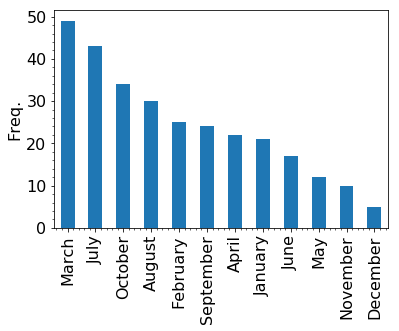

In [10]:
ax = df.datetime.dt.month_name().value_counts().plot(kind='bar')
ax.set_ylabel('Freq.');

#### Consolidating hplc/fluo chlorophyll data

In [11]:
# two types of chlorophyll a:
df.filter(regex='chl', axis=1).info()
# chl: obtained by fluorometry
# chl_a: obtained by hplc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 2 columns):
chl      262 non-null float64
chl_a    33 non-null float64
dtypes: float64(2)
memory usage: 4.6 KB


In [13]:
def fill_chl(row):
    return row['chl_a'] if np.isfinite(row['chl_a']) else row['chl']

In [14]:
# fill consolidated chlor_a column with chl_a (hplc) when possible, chl (fluo) otherwise
df['chlor_a'] = df.apply(fill_chl, axis=1)

In [15]:
# Flag chlor_a measurement type; hplc/fluo 
df['is_hplc'] = np.isfinite(df.chl_a)

In [14]:
df.filter(regex='chl', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 3 columns):
chl        262 non-null float64
chl_a      33 non-null float64
chlor_a    292 non-null float64
dtypes: float64(3)
memory usage: 6.9 KB


In [17]:
# assign Nan to negative depths
df.loc[df.etopo2<=0, 'etopo2'] = np.NaN

In [16]:
# Preprocess satellite data
df_sat = df.filter(regex='sat_rrs', axis=1).copy()
# Invalidate negative readings
df_sat[df_sat<=0] = np.NaN
# Log-transform rrs
df_log_sat = pd.DataFrame(np.log10(df_sat.values),
                          columns=[f'log_{col}' for col in df_sat.columns]
                         )

In [ ]:
# Preprocess 
df_extr = df[['oisst']].merge(df_log_sat,
                                  right_index=True,
                                  left_index=True)

In [18]:
df_extr['coastal'] = df.etopo2<=30
df_extr['coastal'] = df_extr.coastal.astype('category').cat.codes.astype('int')
df_extr['log_chlor_a'] = np.log10(df.chlor_a.values)

In [19]:
df_extr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 9 columns):
oisst             292 non-null float64
log_sat_rrs412    276 non-null float64
log_sat_rrs443    285 non-null float64
log_sat_rrs490    291 non-null float64
log_sat_rrs510    292 non-null float64
log_sat_rrs555    292 non-null float64
log_sat_rrs670    281 non-null float64
coastal           292 non-null int64
log_chlor_a       292 non-null float64
dtypes: float64(8), int64(1)
memory usage: 20.6 KB


### Splitting data into training & testing sets

In [20]:
X = df_extr.loc[:, :'coastal']
y = df_extr.loc[:, ['log_chlor_a']] # extra brackets to retain DataFrame type

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    stratify=X.coastal)

In [22]:
X.coastal.value_counts(normalize=True)*100

0    67.808219
1    32.191781
Name: coastal, dtype: float64

In [23]:
X_train.coastal.value_counts(normalize=True)*100

0    67.579909
1    32.420091
Name: coastal, dtype: float64

In [24]:
X_test.coastal.value_counts(normalize=True)*100

0    68.493151
1    31.506849
Name: coastal, dtype: float64

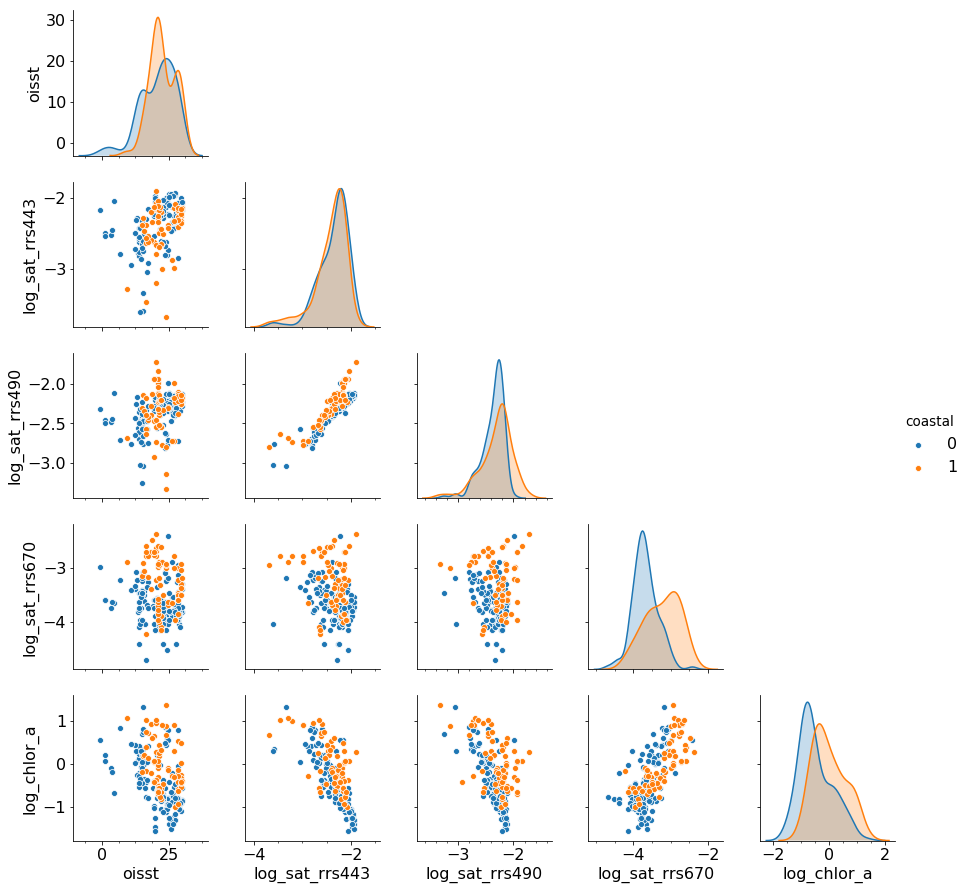

In [25]:
g = sb.pairplot(df_extr.iloc[X_train.index], hue='coastal', vars=['oisst', 'log_sat_rrs443',
                                              'log_sat_rrs490', 'log_sat_rrs670',
                                             'log_chlor_a'])
# mask upper triangle for readability
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
#f = pl.gcf()
g.savefig('./resources/pairgrid.png', dpi=300)

<img src='./resources/pairgrid.png?:2'/>

In [203]:
def make_heatmap(input_, figsize=(6, 5), **heatmap_kwargs):
    f, ax = pl.subplots(figsize=figsize)
    ax.set_facecolor('k')
    corr_mat = input_.dropna().corr().iloc[1:, :-1]
    sb.heatmap(corr_mat, ax=ax, vmin=-1, vmax=1, 
               mask=np.triu(np.ones(corr_mat.shape),k=1), cmap='RdBu', fmt='.2f',
               annot=True, **heatmap_kwargs)
    return f

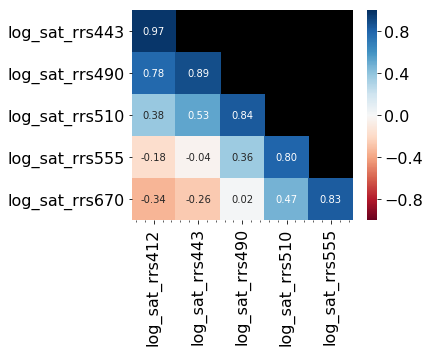

In [27]:
f = make_heatmap(X_train, filter_='rrs')
f.tight_layout()
f.savefig('./resources/heatmap_train.png')

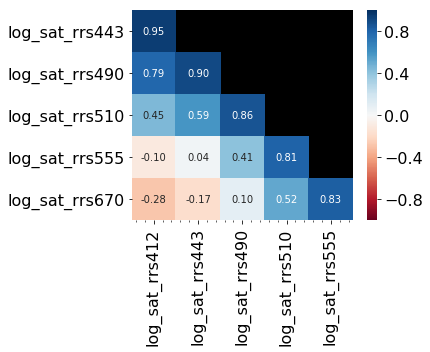

In [28]:
f = make_heatmap(X_test, filter_='rrs')
f.tight_layout()
f.savefig('./resources/heatmap_test.png')

<img src='./resources/heatmap_train.png?:2'/>

### Computing Principle Components

* parameterize PCA transformer using training set
* compute principle components for training set
* compute principle components for testing set with the same PCA transformer

In [29]:
# Isolate Rrs data in both training and test sets
X_train_rrs = X_train.filter(regex='rrs', axis=1).dropna()
X_test_rrs = X_test.filter(regex='rrs', axis=1).dropna()

# Instantiate PCA transformers
pca_transformer = PCA()

In [30]:
# parameterize transformer while rotating training data
X_train_pca = pca_transformer.fit_transform(X=X_train_rrs)

# apply same transformation to test set
X_test_pca = pca_transformer.transform(X=X_test_rrs)

In [31]:
X_train_pca = pd.DataFrame(X_train_pca,
                           columns=[f'PC{i}' for i in range(1, X_train_pca.shape[1]+1)],
                           index=X_train_rrs.index)
X_test_pca =  pd.DataFrame(X_test_pca, 
                           columns=[f'PC{i}' for i in range(1, X_test_pca.shape[1]+1)],
                           index=X_test_rrs.index)

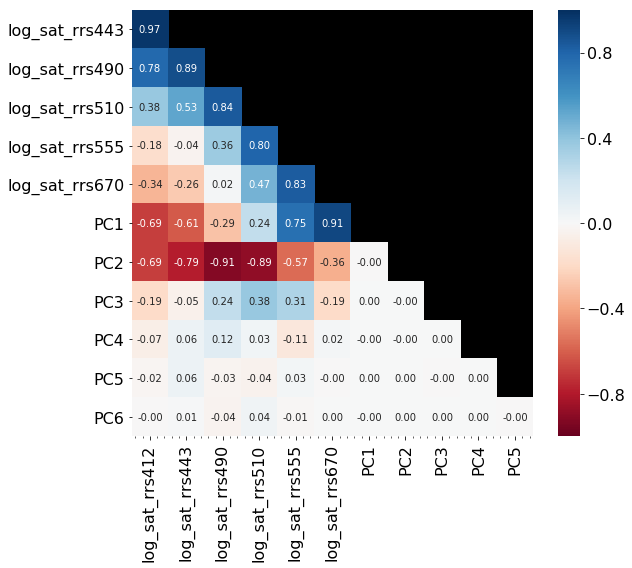

In [32]:
rrs_pc = X_train_rrs.merge(X_train_pca, how='outer',
                                left_index=True, right_index=True)
f = make_heatmap(rrs_pc, figsize=(9, 8))
f.tight_layout()
f.savefig('./resources/heatmap_x_train_pca.png', dpi=300)

<img src='./resources/heatmap_x_train_pca.png?:3' width=600 />

In [33]:
X_train_pca = X_train_pca.merge(X_train[['oisst', 'coastal']], how='outer',
                               right_index=True, left_index=True)
X_test_pca = X_test_pca.merge(X_test[['oisst', 'coastal']], how='outer',
                             right_index=True, left_index=True)

In [34]:
X_train_pca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 0 to 291
Data columns (total 8 columns):
PC1        203 non-null float64
PC2        203 non-null float64
PC3        203 non-null float64
PC4        203 non-null float64
PC5        203 non-null float64
PC6        203 non-null float64
oisst      219 non-null float64
coastal    219 non-null int64
dtypes: float64(7), int64(1)
memory usage: 15.4 KB


In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 88 to 20
Data columns (total 8 columns):
oisst             219 non-null float64
log_sat_rrs412    207 non-null float64
log_sat_rrs443    214 non-null float64
log_sat_rrs490    218 non-null float64
log_sat_rrs510    219 non-null float64
log_sat_rrs555    219 non-null float64
log_sat_rrs670    212 non-null float64
coastal           219 non-null int64
dtypes: float64(7), int64(1)
memory usage: 25.4 KB


### Standardize data:

In [36]:
# Instantiate scalers

sc_X_rrs = StandardScaler()
sc_X_pca = StandardScaler()
sc_y = StandardScaler()

In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 88 to 20
Data columns (total 8 columns):
oisst             219 non-null float64
log_sat_rrs412    207 non-null float64
log_sat_rrs443    214 non-null float64
log_sat_rrs490    218 non-null float64
log_sat_rrs510    219 non-null float64
log_sat_rrs555    219 non-null float64
log_sat_rrs670    212 non-null float64
coastal           219 non-null int64
dtypes: float64(7), int64(1)
memory usage: 25.4 KB


In [38]:
X_train_pca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 0 to 291
Data columns (total 8 columns):
PC1        203 non-null float64
PC2        203 non-null float64
PC3        203 non-null float64
PC4        203 non-null float64
PC5        203 non-null float64
PC6        203 non-null float64
oisst      219 non-null float64
coastal    219 non-null int64
dtypes: float64(7), int64(1)
memory usage: 15.4 KB


In [39]:
# Parameterize scalers while standardizing training sets
X_train_s = sc_X_rrs.fit_transform(X_train.iloc[:, :-1])
X_train_pca_s = sc_X_pca.fit_transform(X_train_pca.iloc[:, :-1])
y_train_s = sc_y.fit_transform(y_train)

In [40]:
X_train_s = pd.DataFrame(X_train_s, index=X_train.index,
                         columns=[f'{col}_s' for col in X_train.iloc[:, :-1].columns])
X_train_s = X_train_s.merge(X_train[['coastal']], how='outer',
                            right_index=True, left_index=True)
X_train_pca_s = pd.DataFrame(X_train_pca_s, index=X_train_pca.index,
                            columns=[f'{col}_s' 
                                     for col in X_train_pca.iloc[:, :-1].columns])
X_train_pca_s = X_train_pca_s.merge(X_train_pca[['coastal']], how='outer',
                                   right_index=True, left_index=True)

In [41]:
y_train_s = pd.DataFrame(y_train_s, columns=y_train.columns, index=y_train.index)

In [42]:
X_train_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 88 to 20
Data columns (total 8 columns):
oisst_s             219 non-null float64
log_sat_rrs412_s    207 non-null float64
log_sat_rrs443_s    214 non-null float64
log_sat_rrs490_s    218 non-null float64
log_sat_rrs510_s    219 non-null float64
log_sat_rrs555_s    219 non-null float64
log_sat_rrs670_s    212 non-null float64
coastal             219 non-null int64
dtypes: float64(7), int64(1)
memory usage: 25.4 KB


In [43]:
X_train_pca_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 0 to 291
Data columns (total 8 columns):
PC1_s      203 non-null float64
PC2_s      203 non-null float64
PC3_s      203 non-null float64
PC4_s      203 non-null float64
PC5_s      203 non-null float64
PC6_s      203 non-null float64
oisst_s    219 non-null float64
coastal    219 non-null int64
dtypes: float64(7), int64(1)
memory usage: 25.4 KB


In [44]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 260 to 220
Data columns (total 8 columns):
oisst             73 non-null float64
log_sat_rrs412    69 non-null float64
log_sat_rrs443    71 non-null float64
log_sat_rrs490    73 non-null float64
log_sat_rrs510    73 non-null float64
log_sat_rrs555    73 non-null float64
log_sat_rrs670    69 non-null float64
coastal           73 non-null int64
dtypes: float64(7), int64(1)
memory usage: 7.6 KB


In [45]:
X_test_pca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 4 to 289
Data columns (total 8 columns):
PC1        66 non-null float64
PC2        66 non-null float64
PC3        66 non-null float64
PC4        66 non-null float64
PC5        66 non-null float64
PC6        66 non-null float64
oisst      73 non-null float64
coastal    73 non-null int64
dtypes: float64(7), int64(1)
memory usage: 5.1 KB


In [46]:
# Standardize test sets with parameterized scalers
X_test_s = sc_X_rrs.transform(X_test.iloc[:, :-1])
X_test_pca_s = sc_X_pca.transform(X_test_pca.iloc[:, :-1])
y_test_s = sc_y.transform(y_test)

In [47]:
X_test_s = pd.DataFrame(X_test_s, index=X_test.index,
                         columns=[f'{col}_s' for col in X_test.iloc[:, :-1].columns])

X_test_s = X_test_s.merge(X_test[['coastal']], how='outer',
                            right_index=True, left_index=True)
X_test_pca_s = pd.DataFrame(X_test_pca_s, index=X_test_pca.index,
                            columns=[f'{col}_s' 
                                     for col in X_train_pca.iloc[:, :-1].columns])
X_test_pca_s = X_test_pca_s.merge(X_test_pca[['coastal']], how='outer',
                                   right_index=True, left_index=True)

In [48]:
y_test_s = pd.DataFrame(y_test_s, columns=y_test.columns, index=y_test.index)

### Modify X_train and X_test to make an OC4 compatible dataset

In [72]:
blue_band_cols = ['log_sat_rrs443', 'log_sat_rrs490', 'log_sat_rrs510']
X_train_OC4 = pd.DataFrame(X_train[blue_band_cols].max(axis=1),
                           columns=['MaxBlue'], index=X_train.index)
X_test_OC4 = pd.DataFrame(X_test[blue_band_cols].max(axis=1),
                          columns=['MaxBlue'], index=X_test.index)
X_train_OC4['MaxBlueID'] = X_train[blue_band_cols].idxmax(axis=1).astype('category')
X_test_OC4['MaxBlueID'] = X_test[blue_band_cols].idxmax(axis=1).astype('category')
X_train_OC4['MaxBlueIdx'] = X_train_OC4['MaxBlueID'].cat.codes
X_test_OC4['MaxBlueIdx'] = X_test_OC4['MaxBlueID'].cat.codes
X_train_OC4['X (MaxBlue2Gr)'] = X_train.MaxBlue - X_train.log_sat_rrs555
X_test_OC4['X (MaxBlue2Gr)'] = X_test.MaxBlue - X_test.log_sat_rrs555
for i in range(2, 5):
    X_train_OC4[f'X{i}'] = X_train_OC4['X (MaxBlue2Gr)'] ** i
    X_test_OC4[f'X{i}'] = X_test_OC4['X (MaxBlue2Gr)'] ** i

In [73]:
X_train_OC4.head(2)

,MaxBlue,MaxBlueID,MaxBlueIdx,X (MaxBlue2Gr),X2,X3,X4
88,-1.968188,log_sat_rrs510,2,0.022787,0.000519,0.000012,2.695956e-07
74,-2.146302,log_sat_rrs490,1,0.022469,0.000505,0.000011,2.548577e-07


In [67]:
X_test_OC4.head()

,MaxBlue,MaxBlueID,MaxBlueIdx,MaxBlue2Gr
260,-2.583359,log_sat_rrs510,2,-0.035146
189,-2.092051,log_sat_rrs443,0,0.723257
187,-2.208309,log_sat_rrs443,0,0.455231
103,-2.194499,log_sat_rrs443,0,0.372532
271,-2.690370,log_sat_rrs510,2,-0.394520


### Before modeling: stash data sets and various transformer objects

In [51]:
train_dict = dict(X_rrs=X_train, X_rrs_s=X_train_s,
                  X_pca=X_train_pca, X_pca_s=X_train_pca_s,
                  X_oc4=X_train_OC4, y=y_train, y_s=y_train_s)

In [52]:
test_dict = dict(X_rrs=X_test, X_rrs_s=X_test_s,
                 X_pca=X_test_pca, X_pca_s=X_test_pca_s, 
                 X_oc4=X_test_OC4, y=y_test, y_s=y_test_s)

In [53]:
transformers_dict = dict(X_rrs_scaler=sc_X_rrs, X_pca_scaler=sc_X_pca, y_scaler=sc_y,
                         pca_tranf=pca_transformer)

In [54]:
preprocess_dict = dict(training=train_dict, testing=test_dict,
                       transformers=transformers_dict)

In [55]:
with open('./preprocess_dicts.pkl', 'wb') as fb:
    pickle.dump(preprocess_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
print(f"{os.path.getsize('./preprocess_dicts.pkl')/1000}kB")

101.708kB


## 4. Models:

* $OC_4$-like polynomial regression model
* Hierarchical $OC_4$-like polynomial model 
* Multivariate regression model with Rrs data
* Multivariate regression model with Rrs data and SST
* Multivariate regression model with PC data 
* Multivariate regression model with PC data and SST

In [59]:
X_train.head()

,oisst,log_sat_rrs412,log_sat_rrs443,log_sat_rrs490,log_sat_rrs510,log_sat_rrs555,log_sat_rrs670,coastal,MaxBlue,MaxBlueId,MaxBlue2Gr
88,21.12,-2.374688,-2.179799,-1.977572,-1.968188,-1.990974,-2.987163,1,-1.968188,2,0.022787
74,15.27,-2.378824,-2.283997,-2.146302,-2.154282,-2.168770,-2.910095,1,-2.146302,1,0.022469
50,16.40,-2.326979,-2.290730,-2.332547,-2.567031,-2.943095,-4.698970,0,-2.290730,0,0.652365
12,22.18,-2.040482,-2.122629,-2.255707,-2.484126,-2.787812,-3.677781,0,-2.122629,0,0.665184
234,4.35,-2.007889,-2.041914,-2.116339,-2.331614,-2.640165,-3.657577,0,-2.041914,0,0.598250


In [60]:
X_train_s.head()

,oisst_s,log_sat_rrs412_s,log_sat_rrs443_s,log_sat_rrs490_s,log_sat_rrs510_s,log_sat_rrs555_s,log_sat_rrs670_s,coastal
88,-0.069042,-0.008739,0.602723,1.571977,2.427183,2.401548,1.237165,1
74,-1.031637,-0.020999,0.270535,0.852391,1.477488,1.685786,1.412853,1
50,-0.845700,0.132671,0.249069,0.058107,-0.628893,-1.431453,-2.665164,0
12,0.105377,0.981865,0.784983,0.385808,-0.205806,-0.806323,-0.337205,0
234,-2.828483,1.078473,1.042305,0.980175,0.572509,-0.211929,-0.291149,0


In [57]:
X_train_pca_s.head()

,PC1_s,PC2_s,PC3_s,PC4_s,PC5_s,PC6_s,oisst_s,coastal
0,0.235672,0.809555,0.076862,0.205850,-0.977104,0.324827,-0.329025,0
1,-0.549944,0.013807,-0.242928,0.315448,0.746546,1.532314,-0.324089,0
2,-0.770027,-0.574232,-1.151153,1.039777,-0.446911,1.031471,0.515097,0
3,1.361573,2.004275,-0.647140,1.426060,-0.328707,0.799141,-0.712418,0
5,NaN,NaN,NaN,NaN,NaN,NaN,-0.761782,0


In [74]:
X_train_OC4.filter(regex='X', axis=1).head()

,X (MaxBlue2Gr),X2,X3,X4
88,0.022787,0.000519,0.000012,2.695956e-07
74,0.022469,0.000505,0.000011,2.548577e-07
50,0.652365,0.425580,0.277634,1.811185e-01
12,0.665184,0.442469,0.294323,1.957792e-01
234,0.598250,0.357904,0.214116,1.280949e-01


In [ ]:
sb.heatmap()

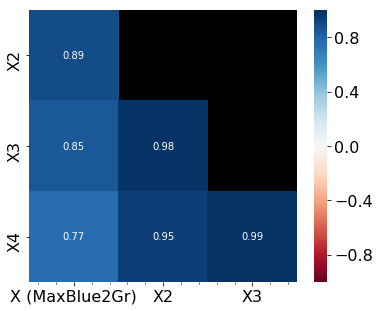

In [201]:
#X_train_OC4_corr = X_train_OC4.filter(regex='X', axis=1).corr()
f = make_heatmap(X_train_OC4.filter(regex='X', axis=1))
heatmap()
f.savefig('./resources/heatmap_x_train_oc4.png', dpi=300)

<img src='./resources/heatmap_x_train_oc4.png' width=400/>

In [89]:
X_oc4 = shared(X_train_OC4.filter(regex='X', axis=1).values)

### $OC_4$-like polynomial regression:
<br><br>
<span style="font-size:12">
$$\large{log_{10}(chl) = log_{10} \left ( \frac{max(Rrs_{443}, Rrs_{490}, Rrs_{510})}{Rrs_{555}}\right)}$$
</span>

In [94]:
with pm.Model() as m_oc4:
    α = pm.Normal('α', 0, 1) # prior on intercept
    β = pm.Normal('β', 0, 5, shape=4) # prior on slopes
    σ = pm.Exponential('σ', 1) # prior on likelihood variance
    μ = α + pm.math.dot(X_oc4, β) # likelihood's mean deterministic model
    y_oc4 = pm.Normal('y_oc4', mu=μ, sd=σ, observed=y_train.values) # likelihood

In [95]:
m_oc4_graph = pm.model_to_graphviz(m_oc4)
m_oc4_graph.render(filename='m_oc4_graph', directory='./resources/', format='png');

<img src='./resources/m_oc4_graph.png'/>

### Prior Checks

In [172]:
x_dummy = np.linspace(-1., 1., num=50).reshape(-1, 1)
x_dummy = np.array([np.power(x_dummy, i) for i in range(1, 5)]).squeeze()

In [175]:
priors = pm.sample_prior_predictive(model=m_oc4, vars=['α', 'β', 'y_oc4'])
β_prior = priors['β']
α_prior = priors['α'].reshape(-1, 1)
y_oc4_prior = priors['y_oc4']
oc4_lines = α_prior + np.dot(β_prior, x_dummy)

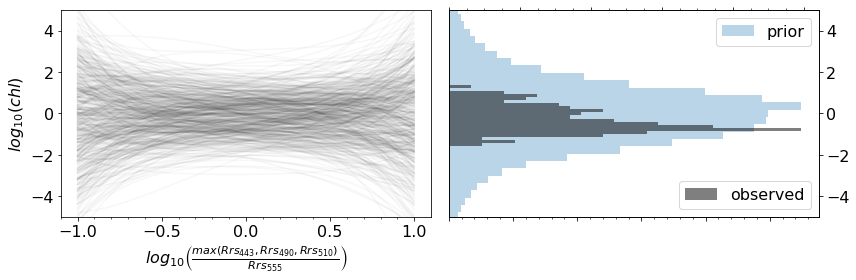

In [196]:
f, ax = pl.subplots(ncols=2, figsize=(12, 4))
for i in range(500):
    ax[0].plot(x_dummy[0], oc4_lines[i], alpha=0.03, color='k')
ax[0].set_ylim(-5, 5);
ax[0]. set_xlabel(r'$ log_{10} \left( \frac{max(Rrs_{443}, Rrs_{490}, Rrs_{510})}{Rrs_{555}}\right)$')
ax[0].set_ylabel(r'$log_{10}(chl)$')
ax[1].hist(priors['y_oc4'].flatten(), density=True, alpha=0.3, bins=100,
           orientation='horizontal', label='prior');
ax[1].set_ylim(-5, 5)
ax[1].set_xticklabels([])
ax[1].yaxis.tick_right()
ax[1].legend()
ax2 = ax[1].twiny()
ax2.hist(y_train.values, color='k', density=True, alpha=0.5, bins=20,
         orientation='horizontal', label='observed');
ax2.set_xticklabels([])
ax2.legend(loc='lower right')
f.tight_layout()
f.savefig('./resources/priors_predictive_oc4_wk_reg.png', dpi=300)

In [96]:
with m_oc4:
    trace_oc4 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains: 100%|██████████| 6000/6000 [03:15<00:00, 30.72draws/s]


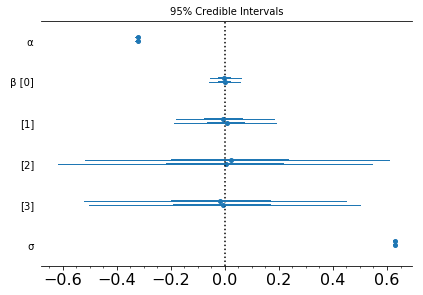

In [198]:
pm.forestplot(trace=trace_oc4, varnames=['α', 'β', 'σ'], rhat=False);